# An analysis of goal scoring in Rocket League

This months kaggle tabular playground looked really interesting [https://www.kaggle.com/competitions/tabular-playground-series-oct-2022]. A lot of people have already shown some interesting modelling and prediction, so I thought it would be fun to do a statistical analysis from a gameplay persective. I also get to use some epidemiological modelling ideas ('survivival analysis'), which aren't as commonly considered in modern ML literature.  

I largely had two questions of interest in this analysis

1.   What is the expected time that it takes for a goal to be scored after 'kickoff'.
2.   Does either team have some statistically relevant advantage in in reagrd to scoring? Particuarly immediately from kickoff?

Note here I use 'kickoff' to include both the kickoff at the beginning of the game and when the ball is reset after a goal is scored.

In particular I think this analysis (objective 2) would be interesting to investigate. A lot of games have a noticable bias in win probabilities between teams [https://www.factor.gg/article/not-just-this-or-that-blue-vs-red-side-analysis]. If such a bias is present, it could suggest that the game designers should consider attempting to counteract this to maintain competitive viablity.   





# Import data

I ran this on google colab. To import the data you'll need to have a kaggle account and download your kaggle API key ('kaggle.json'). Upload that the colab notebook that you have opened this in, then run the following code.


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle competitions download -c tabular-playground-series-oct-2022

100% 3.49G/3.49G [00:35<00:00, 186MB/s]
100% 3.49G/3.49G [00:35<00:00, 105MB/s]


In [4]:
! unzip 'tabular-playground-series-oct-2022.zip'

Archive:  tabular-playground-series-oct-2022.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test_dtypes.csv         
  inflating: train_0.csv             
  inflating: train_1.csv             
  inflating: train_2.csv             
  inflating: train_3.csv             
  inflating: train_4.csv             
  inflating: train_5.csv             
  inflating: train_6.csv             
  inflating: train_7.csv             
  inflating: train_8.csv             
  inflating: train_9.csv             
  inflating: train_dtypes.csv        


Let's start off with an install. We're going to use the package 'lifelines' for some survival analysis, so install that if you don't already have it.

In [ ]:
## Installs
! pip install lifelines

Next the imports. I'm using the basic data science stack with the addition of some important functions from lifelines. I also import the scipy.stats.beta class for some statistical analysis. 


In [6]:
## Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import beta
from lifelines import KaplanMeierFitter
from lifelines import (WeibullFitter, ExponentialFitter,
LogNormalFitter, LogLogisticFitter)
from lifelines.utils import median_survival_times

Let's import the data (this takes some time). Only thing to note here is that I'm only importing 

In [7]:
# import pandas as pd
# ## Getting the data
# dtypes_df = pd.read_csv('/kaggle/input/tabular-playground-series-oct-2022/train_dtypes.csv')
# dtypes_df

In [8]:
## Getting the data
dtypes_df = pd.read_csv('train_dtypes.csv')
dtypes_df

,column,dtype
0,game_num,int32
1,event_id,int32
2,event_time,float32
3,ball_pos_x,float32
4,ball_pos_y,float32
...,...,...
56,boost5_timer,float16
57,player_scoring_next,int8
58,team_scoring_next,object
59,team_A_scoring_within_10sec,int8


In [9]:
## Getting the data
dtypes = {k: v for (k, v) in zip(dtypes_df.column, dtypes_df.dtype)}
fields = ['event_id', 'event_time','team_scoring_next']
df_list = []

for i in range(10):
  print(f'On file {i}') 
  filename = f'train_{i}.csv'
  _df = (pd.read_csv(filename, index_col=None, header=0, dtype=dtypes, usecols=fields)
        .groupby('event_id').first())
  df_list.append(_df)

df = pd.concat(df_list, axis=0, ignore_index=True)


On file 0
On file 1
On file 2
On file 3
On file 4
On file 5
On file 6
On file 7
On file 8
On file 9


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30528 entries, 0 to 30527
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   event_time         30528 non-null  float32
 1   team_scoring_next  25366 non-null  object 
dtypes: float32(1), object(1)
memory usage: 357.9+ KB


# Survival Analysis

First, let's just do a quick visual check and calculate some statistics.

mean: 67.49 seconds
median: 49.17 seconds
modal 5 seconds: 5-10


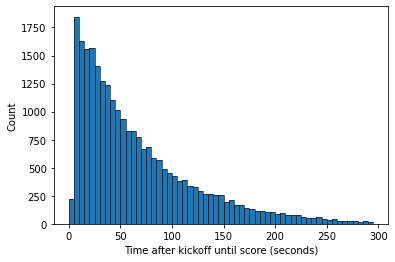

In [18]:
time_to_score_series = df.dropna(axis='rows')['event_time']

n , bins, _ = plt.hist(-time_to_score_series, bins = np.arange(0,300,5))
mode_index = n.argmax()  
print(f'mean: {-time_to_score_series.mean() :.2f} seconds')
print(f'median: {-time_to_score_series.median() :.2f} seconds')
print(f'modal 5 seconds: {bins[n.argmax()]}-{bins[n.argmax()+1]}')

sns.histplot(-time_to_score_series, bins = np.arange(0,300,5)) # Multiply by -1 to get time until goal
plt.xlabel('Time after kickoff until score (seconds)')
plt.show()

Ok, that looks like we might expect it to. Very unlikely for a goal to be scored in the first few seconds (it takes some amount of time to score), then the time to goal looks to roughly follow a poisson process [https://gtribello.github.io/mathNET/resources/jim-chap20.pdf, figure 20.1].

Now lets do a formal 'survival analysis'. In our data there a quite a few events where 'team_scoring_next' is NaN. In this case we do not know how long it would have taken for a goal to be scored, as the game ended first.

However, we do know at least that it was going to take at least until that game end for a goal to occur. This is an example of right-censoring. Luckly there is a cool library called 'lifelines' that will account for that. It's worth reading around the literature, but for now lets just fit a model. 

In [19]:
## Set up data to fit

survival_df =  pd.DataFrame({'t' : [],
                     'goal_status': []})
survival_df['t'] = -1 * df[['event_time']].copy()
survival_df['goal_status'] = np.where((df['team_scoring_next'] == 'A') | (df['team_scoring_next'] == 'B') ,True,False) # True if a goal is scored, false if censored
survival_df

,t,goal_status
0,33.313030,True
1,135.037476,True
2,69.087517,True
3,9.546700,True
4,46.077991,True
...,...,...
30523,10.691553,True
30524,16.589708,True
30525,105.996834,True
30526,94.513321,True


 Median time to goal score:1.004581093788147 (minutes) or  60.27 second
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                0.990017                1.019426


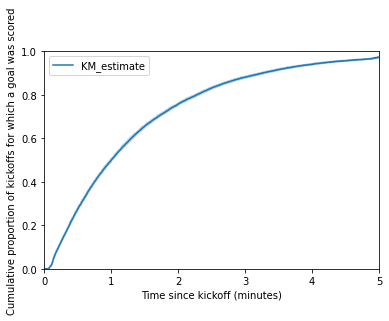

In [20]:
kmf = KaplanMeierFitter()
kmf.fit(durations = survival_df["t"]/60, event_observed =survival_df["goal_status"])

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(f' Median time to goal score:{median_} (minutes) or {60*median_: .2f} second')
print(median_confidence_interval_)

kmf.plot_cumulative_density()
plt.xlabel('Time since kickoff (minutes)')
plt.ylabel('Cumulative proportion of kickoffs for which a goal was scored')
plt.xlim(0,5)
plt.ylim(0,1)
plt.show()

Wow! That's a really smooth curve! The only bit that doesn't look smooth is in the first 10 seconds.Let's zoom in. 

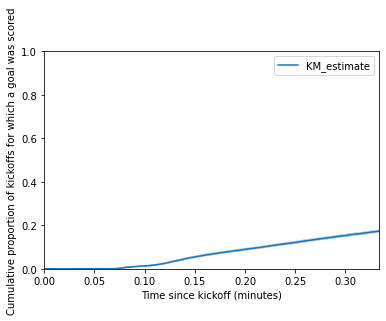

In [21]:
kmf.plot_cumulative_density()
plt.xlabel('Time since kickoff (minutes)')
plt.ylabel('Cumulative proportion of kickoffs for which a goal was scored')
plt.xlim(0,1/3)
plt.ylim(0,1)
plt.show()

The non-parametric surivival function has been able to highlight that typically it is highly unlikely for a goal to be scored in the first 7 seconds. The fastest goal I could locate with 2 minutes of googling was ~3 seconds, with a direct shot on goal.

Let's look at some parameteric functions, using AIC to choose the best. 

In [22]:
best_model = None
best_aic = np.inf
for model in [WeibullFitter, ExponentialFitter,
              LogNormalFitter, LogLogisticFitter]:
              exf = model()
              exf.fit(durations = survival_df["t"]/60, event_observed =survival_df["goal_status"])
              if exf.AIC_ < best_aic:
                best_aic = exf.AIC_
                best_model = exf
best_model.print_summary()


<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 30528 total observations, 5162 right-censored observations>
   number of observations = 30528
number of events observed = 25366
           log-likelihood = -33884.23
               hypothesis = mu_ != 0, sigma_ != 1

---
         coef   se(coef)   coef lower 95%   coef upper 95%
mu_     -0.07       0.01            -0.08            -0.06
sigma_   1.04       0.00             1.03             1.05

         cmp to      z      p   -log2(p)
mu_        0.00 -11.22 <0.005      94.63
sigma_     1.00   8.83 <0.005      59.78
---
AIC = 67772.46

The LogNormalFitter appears to be best for the full dataset. Let's plot both the cdf of the survival curve and the survival function for this as well.

Median time to goal score is 0.93 minutes or 55.98 seconds


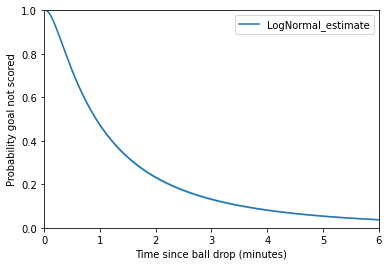

In [23]:
print(f'Median time to goal score is{best_model.median_survival_time_: .2f} minutes or{60*best_model.median_survival_time_: .2f} seconds')
best_model.plot_survival_function()
plt.xlabel('Time since ball drop (minutes)')
plt.ylabel('Probability goal not scored')
plt.xlim(0,6)
plt.ylim(0,1)
plt.show()

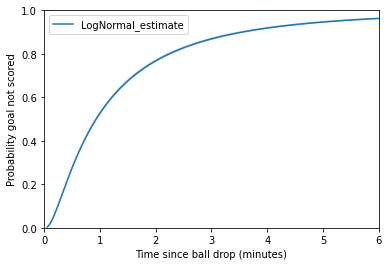

In [24]:

best_model.plot_cumulative_density()
plt.xlabel('Time since ball drop (minutes)')
plt.ylabel('Probability goal not scored')
plt.xlim(0,6)
plt.ylim(0,1)
plt.show()

Overall a very similar curve qualitatively. I'd be more inclined to trust the Kaplar Meier curve though, particuarly given that it highlighted something that seems intuitively reasonable (there is some minimum time needed to score a goal from kickoff).

# Bias in scoring from kickoff.

From the above analysis it appears that in general we should expect a goal to be scored approximately once a minute on average. Scoring in ten seconds or less would be impressive (although modal). I was interested into whether either team had an advantage with regard to immediate shots on goal.

Let's also put a threshold saying that we would want to re-balance the game if either team truly scores more than 55% of goals (either in general or from kickoff).

First let's see whether Rocket League is a fair game for both teams in general. 

In [52]:
## Overall bias in goal scoring

goals_for_each_team = df['team_scoring_next'].value_counts()

A_scores = goals_for_each_team['A']
B_scores = goals_for_each_team['B']
total = A_scores + B_scores

dist = beta(A_scores+1, B_scores+1) # Laplace Smoothing
print(A_scores, B_scores)
print(f'A scores rather than B {100*A_scores/total :.2f} percentage of the time')
print(f'The 89% confidence interval is [{100* dist.ppf(0.055):.2f},{100* dist.ppf(0.945):.2f}]') 
print(f'We can be {100*dist.cdf(0.55) :.2f} % sure that A does not score more than 55% of goals')
print(f'We can be {100 -100*dist.cdf(0.45) :.2f} % sure that B does not score more than 55% of goals')
print(f'We can be {100*(dist.cdf(0.55)-dist.cdf(0.45)) :.2f} % sure that we are in the 45-55% zone for goal scores in general')


12888 12478
A scores rather than B 50.81 percentage of the time
The 89% confidence interval is [50.31,51.31]
We can be 100.00 % sure that A does not score more than 55% of goals
We can be 100.00 % sure that B does not score more than 55% of goals
We can be 100.00 % sure that we are in the 45-55% zone for goal scores in general




This shows that there does seem to be some advantage to team A. I don't have enough domain knowledge to postulate a reason for this. This is only a slight advantage if it does exist, and we can be confident that it was below the defined 55% advantage threshold that we set. This therefore may not warrant action. 

Why an 89% confidence interval rather than the more traditional 95%? See https://xcelab.net/rm/statistical-rethinking/ for a more indepth discussion, but largely as an attempt to draw attention to how arbirtary 95% is. The interested reader can determine that this finding is still significant at the 95% confidence level (up to a 98.9% confidence interval truly).

With that somewhat surprising finding, let's move on to whether team A also have an advantage from the kickoff. I'm going to consider two thresholds to define 'scoring from kickoff'. The first is ten seconds, given that 5-10 seconds was the modal 5 second period for scoring. The second is 7 seconds, which from the Kaplan Meier plot we would expect to require almost perfect circumstance to occur (eg. a direct and unblocked shot on goal). 

In [49]:
## Kickoff advantage in goal scoring
seconds = 10

goals_for_each_team = df[(df['event_time'] >= -seconds)]['team_scoring_next'].value_counts()

A_scores = goals_for_each_team['A']
B_scores = goals_for_each_team['B']
total = A_scores + B_scores

dist = beta(A_scores+1, B_scores+1) # Laplace Smoothing
print(A_scores, B_scores)
print(f'A scores rather than B {100*A_scores/total :.2f} percentage of the time that a goal is scored within {seconds} second after kick-off')
print(f'The 89% confidence interval is [{100* dist.ppf(0.055):.2f},{100* dist.ppf(0.945):.2f}]')
print(f'We can be {100*dist.cdf(0.55) :.2f} % sure that A does not score more than 55% of goals that occur within {seconds} seconds of kickoff')
print(f'We can be {100 -100*dist.cdf(0.45) :.2f} % sure that B does not score more than 55% of goals that occur within {seconds} seconds of kickoff')
print(f'We can be {100*(dist.cdf(0.55)-dist.cdf(0.45)) :.2f} % sure that we are in the 45-55% zone for goal scores within {seconds} seconds of kickoff')

1038 1025
A scores rather than B 50.32 percentage of the time that a goal is scored within 10 second after kick-off
The 89% confidence interval is [48.56,52.07]
We can be 100.00 % sure that A does not score more than 55% of goals that occur within 10 seconds of kickoff
We can be 100.00 % sure that B does not score more than 55% of goals that occur within 10 seconds of kickoff
We can be 100.00 % sure that we are in the 45-55% zone for goal scores within 10 seconds of kickoff


In [51]:
seconds = 7

goals_for_each_team = df[(df['event_time'] >= -seconds)]['team_scoring_next'].value_counts()

A_scores = goals_for_each_team['A']
B_scores = goals_for_each_team['B']
total = A_scores + B_scores

dist = beta(A_scores+1, B_scores+1) # Laplace Smoothing
print(A_scores, B_scores)
print(f'A scores rather than B {100*A_scores/total :.2f} percentage of the time that a goal is scored within {seconds} second after kick-off')
print(f'The 89% confidence interval is [{100* dist.ppf(0.055):.2f},{100* dist.ppf(0.945):.2f}]')
print(f'We can be {100*dist.cdf(0.55) :.2f} % sure that A does not score more than 55% of goals that occur within {seconds} seconds of kickoff')
print(f'We can be {100 -100*dist.cdf(0.45) :.2f} % sure that B does not score more than 55% of goals that occur within {seconds} seconds of kickoff')
print(f'We can be {100*(dist.cdf(0.55)-dist.cdf(0.45)) :.2f} % sure that we are in the 45-55% zone for goal scores within {seconds} seconds of kickoff')

353 315
A scores rather than B 52.84 percentage of the time that a goal is scored within 7 second after kick-off
The 89% confidence interval is [49.75,55.91]
We can be 86.92 % sure that A does not score more than 55% of goals that occur within 7 seconds of kickoff
We can be 100.00 % sure that B does not score more than 55% of goals that occur within 7 seconds of kickoff
We can be 86.92 % sure that we are in the 45-55% zone for goal scores within 7 seconds of kickoff


So (according to this data set) we don't have any statistical evidence to support suggesting that either team has an advantage from kick-off. Why then does team A have a slight advantage in goal scoring? In the absence of detailed knowledge about the data generating process, I'm somewhat inclined to believe that this is a quirk of the dataset.

Therefore the overall finding are


1.   Depending on the model, the expected time to score is either 55 seconds or ~60 seconds. With this amount of data, I'm more inclined to trust the non-parametric model (so 60 seconds). The most common time to score was between 5 and 10 seconds. A fun demonstration of the difference between median and mode!
2.   I didn't find evidence to convince me that either team had an advantage from kickoff. However, at least in this data set, team A scored slightly more often that team B (50.32% of goals). With no asymmetry in the game that I'm aware of, this seems a little strange. Potentially some asymmetry does exist, maybe it is a quirk of how this data was sampled, or potentially it is just down to chance. There is reasonably strong evidence in all cases that the 55% threshold was respected.

All in all I certainly don't think that this analysis suggests the developers need to re-balance their game. The only consideration would be in whether the developers are happy with there being an expected ~minute long period between goals. As goals are likely an emotional high point for players, designers may care about this frequency. If having ~five goals per game is in line with the designers' vision, then no changes need to be made. 



